In [1]:
import numpy as np
import os
import matlab.engine
import matplotlib.pyplot as plt
from Camera_util import parse_video, parse_mean_video
import pandas as pd
from natsort import natsorted
import time
import Camera_util 
import importlib
import pickle
import scipy.io
import heapq
from collections.abc import Iterable

In [2]:
recordings_dir = '/Users/zacharykelly/Aguirre-Brainard Lab Dropbox/Zachary Kelly/FLIC_data/klein'
experiment_filename = '200FPS'
light_levels = [str(i) for i in range(4)]

Generating TTF : 0NDF
Reading in 200FPS 0NDF videos...
Reading 0NDF 3.0hz from 200FPS_3.0hz_0NDF.avi
Warmup settings from: 200FPS_0hz_0NDF_warmup_settingsHistory.pkl
Video settings from: 200FPS_3.0hz_0NDF_settingsHistory.pkl
Reading 0NDF 50.0hz from 200FPS_50.0hz_0NDF.avi
Warmup settings from: 200FPS_0hz_0NDF_warmup_settingsHistory.pkl
Video settings from: 200FPS_50.0hz_0NDF_settingsHistory.pkl
Reading 0NDF 12.0hz from 200FPS_12.0hz_0NDF.avi
Warmup settings from: 200FPS_0hz_0NDF_warmup_settingsHistory.pkl
Video settings from: 200FPS_12.0hz_0NDF_settingsHistory.pkl
Reading 0NDF 0.2hz from 200FPS_0.2hz_0NDF.avi
Warmup settings from: 200FPS_0hz_0NDF_warmup_settingsHistory.pkl
Video settings from: 200FPS_0.2hz_0NDF_settingsHistory.pkl
Reading 0NDF 25.0hz from 200FPS_25.0hz_0NDF.avi
Warmup settings from: 200FPS_0hz_0NDF_warmup_settingsHistory.pkl
Video settings from: 200FPS_25.0hz_0NDF_settingsHistory.pkl
Reading 0NDF 1.0hz from 200FPS_1.0hz_0NDF.avi
Warmup settings from: 200FPS_0hz_0NDF_wa

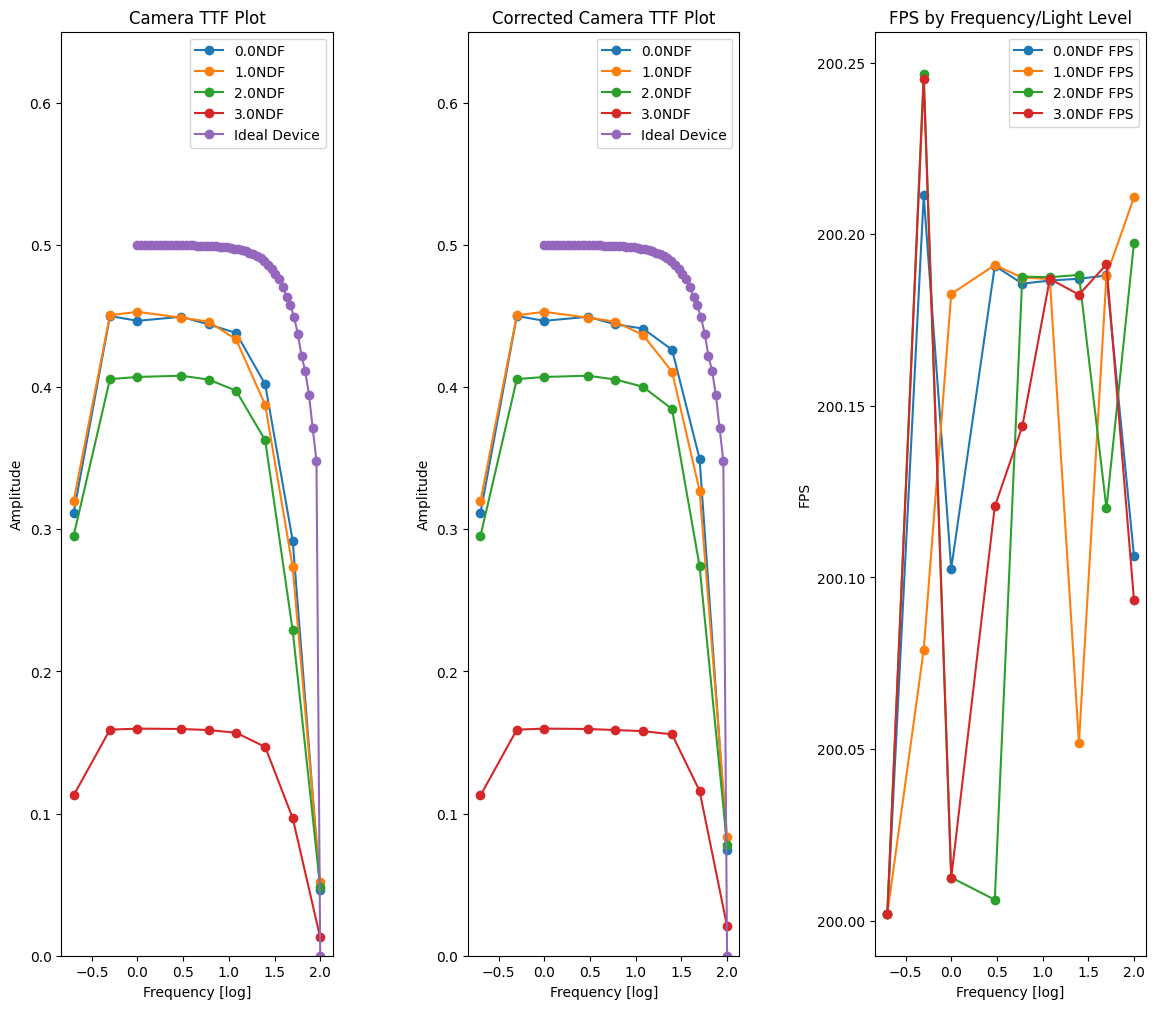

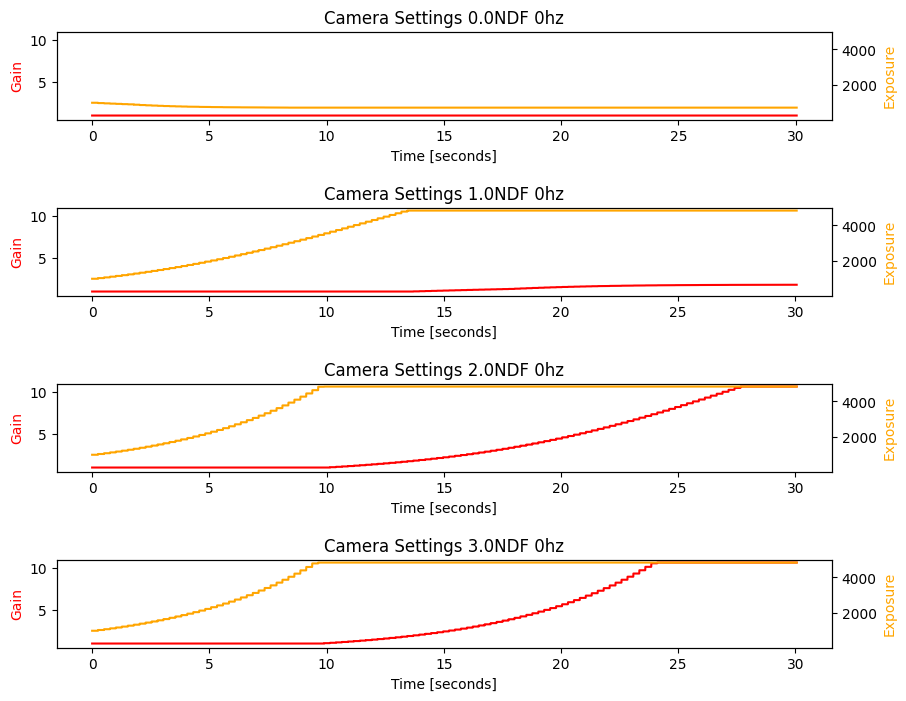

In [5]:
importlib.reload(Camera_util)
Camera_util.generate_klein_ttf(recordings_dir, experiment_filename)

Generating TTF : 0NDF
Reading in 200FPS 0NDF videos...
Reading 0NDF 3.0hz from 200FPS_3.0hz_0NDF.avi
Warmup settings from: 200FPS_0hz_0NDF_warmup_settingsHistory.pkl
Video settings from: 200FPS_3.0hz_0NDF_settingsHistory.pkl
Reading 0NDF 50.0hz from 200FPS_50.0hz_0NDF.avi
Warmup settings from: 200FPS_0hz_0NDF_warmup_settingsHistory.pkl
Video settings from: 200FPS_50.0hz_0NDF_settingsHistory.pkl
Reading 0NDF 12.0hz from 200FPS_12.0hz_0NDF.avi
Warmup settings from: 200FPS_0hz_0NDF_warmup_settingsHistory.pkl
Video settings from: 200FPS_12.0hz_0NDF_settingsHistory.pkl
Reading 0NDF 0.2hz from 200FPS_0.2hz_0NDF.avi
Warmup settings from: 200FPS_0hz_0NDF_warmup_settingsHistory.pkl
Video settings from: 200FPS_0.2hz_0NDF_settingsHistory.pkl
Reading 0NDF 25.0hz from 200FPS_25.0hz_0NDF.avi
Warmup settings from: 200FPS_0hz_0NDF_warmup_settingsHistory.pkl
Video settings from: 200FPS_25.0hz_0NDF_settingsHistory.pkl
Reading 0NDF 1.0hz from 200FPS_1.0hz_0NDF.avi
Warmup settings from: 200FPS_0hz_0NDF_wa

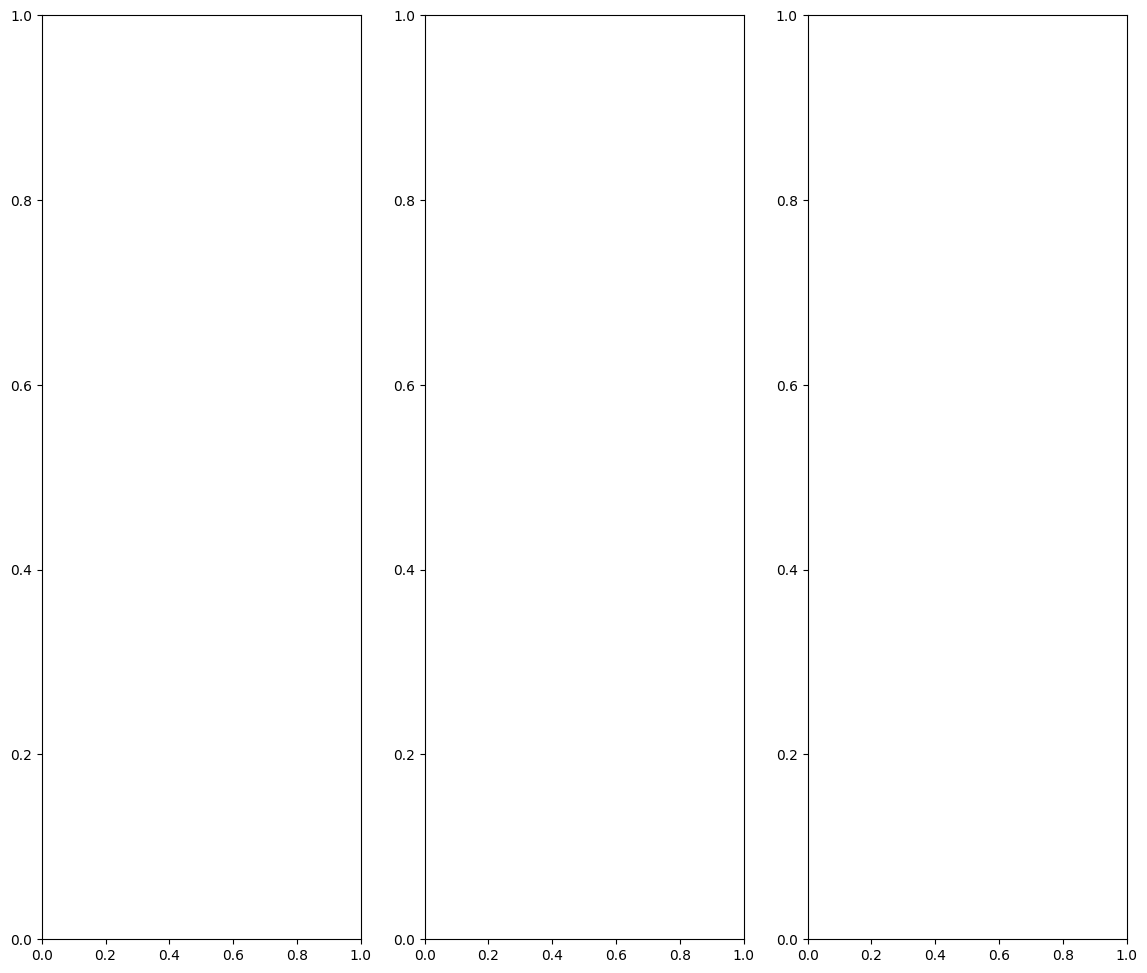

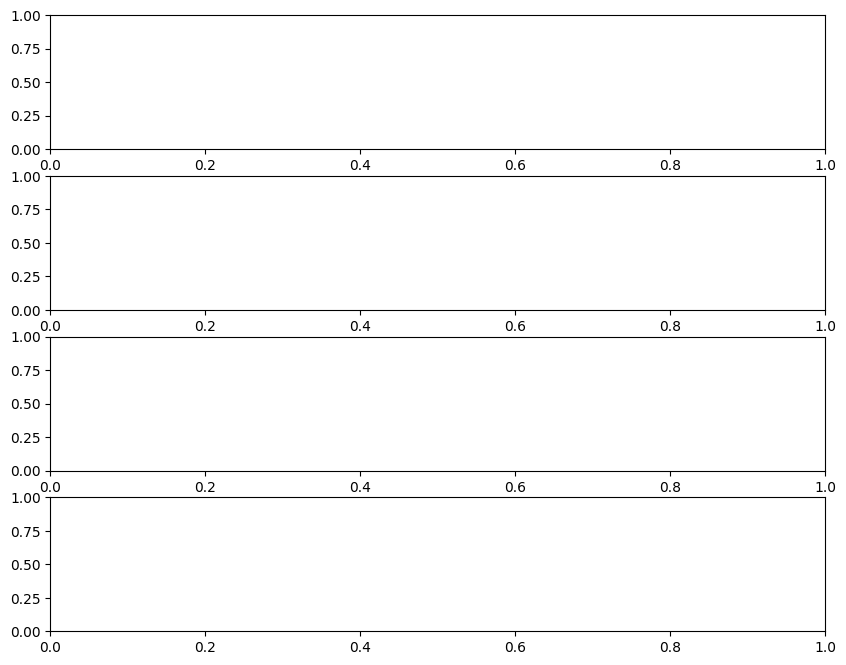

In [3]:
eng = matlab.engine.start_matlab()
eng.addpath('/Users/zacharykelly/Documents/MATLAB/toolboxes/combiLEDToolbox/code/calibration/measureFlickerRolloff/')

# Create a mapping between light levels and their (frequencies, amplitudes)
light_level_ts_map: dict = {Camera_util.str2ndf(light_level) : Camera_util.analyze_temporal_sensitivity(recordings_dir, experiment_filename, light_level)
                                                    for light_level in light_levels}

# Create a mapping of the frequencies and their verified amplitudes 
# via the Klein chromasurf software
klein_frequencies_and_amplitudes: dict = {freq : amp 
                                          for freq, amp
                                          in zip([6,12,25,50,100], np.array([0.5,0.4965,0.4715,0.4175,0.31]) / 0.5)}


# Create a TTF plot to measure data
ttf_fig, (ttf_ax0, ttf_ax1, ttf_ax2) = plt.subplots(1, 3, figsize=(14,12))

# Create a plot to measure warmup times per light-level
warmup_fig, warmup_axes = plt.subplots(len(light_level_ts_map), 1, figsize=(10,8))

# Ensure warmup_axes is an iterable object
warmup_axes = warmup_axes if isinstance(warmup_axes, Iterable) else [warmup_axes]


In [6]:
CAM_FPS = 200

# Plot the light levels' amplitudes by frequencies
for ind, (light_level, (frequencies, amplitudes, videos_fps, warmup_settings)) in enumerate(light_level_ts_map.items()):  
    # Find the corrected amplitude for these frequencies
    corrected_amplitudes: np.array = np.array([amp if freq not in klein_frequencies_and_amplitudes 
                                                else amp / klein_frequencies_and_amplitudes[freq] 
                                                for freq, amp 
                                                in zip(frequencies, amplitudes)])


    # Plot the amplitude and FPS
    ttf_ax0.plot(np.log10(frequencies), amplitudes, linestyle='-', marker='o', label=f"{light_level}NDF")
    ttf_ax1.plot(np.log10(frequencies), corrected_amplitudes, linestyle='-', marker='o', label=f"{light_level}NDF")
    ttf_ax2.plot(np.log10(frequencies), videos_fps, linestyle='-', marker='o', label=f"{light_level}NDF FPS")
    
    # Retrieve info to plot the camera settings over the warmup period
    gain_axis = warmup_axes[ind]
    gain_history: np.array = warmup_settings[0]['gain_history']
    exposure_history: np.array = warmup_settings[0]['exposure_history']
    warmup_t: np.array = np.arange(0, len(gain_history)/CAM_FPS, 1/CAM_FPS)

    # Plot the gain of the camera over the course of the warmup video
    gain_axis.plot(warmup_t, gain_history, color='red', label='Gain') 
    gain_axis.set_title(f'Camera Settings {light_level}NDF {frequencies[0]}hz')
    gain_axis.set_xlabel('Time [seconds]')
    gain_axis.set_ylabel('Gain', color='red')
    gain_axis.set_ylim([0.5,11])
    
    # Plot the exposure of the camera over the course of the warmup video on the same plot
    # but with a different axis
    exposure_axis = gain_axis.twinx()
    exposure_axis.plot(warmup_t, exposure_history, color='orange', label='Exposure Time')
    exposure_axis.set_ylabel('Exposure', color='orange')
    exposure_axis.set_ylim([35,5000])

# Retrieve the ideal device curve from MATLAB
eng = matlab.engine.start_matlab() 
sourceFreqsHz = matlab.double(np.logspace(0,2))
dTsignal = 1/CAM_FPS
ideal_device_curve = np.array(eng.idealDiscreteSampleFilter(sourceFreqsHz, dTsignal)).flatten() * 0.5

# Add the ideal device to the plot
ttf_ax0.plot(np.log10(sourceFreqsHz).flatten(), ideal_device_curve, linestyle='-', marker='o', label=f"Ideal Device")
ttf_ax1.plot(np.log10(sourceFreqsHz).flatten(), ideal_device_curve, linestyle='-', marker='o', label=f"Ideal Device")

# Standardize the y axis scale
ttf_ax0.set_ylim([0, 0.65])
ttf_ax1.set_ylim([0, 0.65])

# Close the MATLAB engine 
eng.quit()

# Label TTF and FPS plot
ttf_ax0.set_xlabel("Frequency [log]")
ttf_ax0.set_ylabel("Amplitude")
ttf_ax0.set_title("Camera TTF Plot")
ttf_ax0.legend()

ttf_ax1.set_xlabel("Frequency [log]")
ttf_ax1.set_ylabel("Amplitude")
ttf_ax1.set_title("Corrected Camera TTF Plot")
ttf_ax1.legend()

ttf_ax2.set_xlabel("Frequency [log]")
ttf_ax2.set_ylabel("FPS")
ttf_ax2.set_title("FPS by Frequency/Light Level")
ttf_ax2.legend()

# Adjust spacing between subplots
ttf_fig.subplots_adjust(hspace=2)
ttf_fig.subplots_adjust(wspace=0.5)
warmup_fig.subplots_adjust(hspace=1)

# Save the figure
ttf_fig.savefig('/Users/zacharykelly/Aguirre-Brainard Lab Dropbox/Zachary Kelly/FLIC_admin/Equipment/SpectacleCamera/calibration/graphs/CameraTemporalSensitivity.pdf')
warmup_fig.savefig('/Users/zacharykelly/Aguirre-Brainard Lab Dropbox/Zachary Kelly/FLIC_admin/Equipment/SpectacleCamera/calibration/graphs/warmupSettings.pdf')

plt.show()